# Audio Device Streaming
In this notebook we'll investigate how to stream realtime audio data from the microphone in Python.

We'll be using [PyAudio](http://people.csail.mit.edu/hubert/pyaudio/docs/).

In [1]:
import pyaudio
import time

## Installation
1. Determine Python version and 32/64 bit.
2. Obtain a wheel from this site of [pre-built wheels](https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyaudio) or build your own
    I'm using python 3.7.4 64 bit, so my selection was **PyAudio-0.2.11-cp37-cp37m-win_amd64.whl**
3. ```pip install {wheelname}```

## Working with PyAudio
Prerequisites for opening a sound stream with ```pyaudio.open```:
 * **Format**. A PortAudio format constant from ```pyaudio.get_format_from_width()```
 * **Channels**
 * **Rate**
 * **output**
 * **stream_callback**
 
 Notes from the [Port Audio API documentation](http://portaudio.com/docs/v19-doxydocs/portaudio_8h.html#a8a60fb2a5ec9cbade3f54a9c978e2710):
 > The PortAudio stream callback runs at very high or real-time priority. It is required to consistently meet its time deadlines. Do not allocate memory, access the file system, call library functions or call other functions from the stream callback that may block or take an unpredictable amount of time to complete.

In [4]:
import pyaudio
import time

pyaudio_format = pyaudio.paInt16 # 2 byte wide audio samples. Same result as calling p.get_format_from_width(2).
rate = 44100 # Sampling rate
seconds_per_buffer = 0.2 # How much audio we want included in each callback.
frames_per_buffer = int(rate * seconds_per_buffer) # How many samples we get per callback.

desired_seconds = 3
desired_frames = desired_seconds * rate

frames = []
total_frames = 0
# Note that PyAudio will call the callback function in a separate thread.
def callback(in_data, frame_count, time_info, status):
    global total_frames
    frames.append(in_data)
    total_frames += frame_count
    print('total_frames=%d len(in_data)=%d frame_count=%d' % (total_frames, len(in_data), frame_count))
    
    done = total_frames >= desired_frames
    if done:
        flag = pyaudio.paComplete
    else:
        flag = pyaudio.paContinue
    return (None, flag)

p = pyaudio.PyAudio() # (1) Instantiate PyAdio. Sets up the portaudio system.
# input_device_index=.  If not specified uses the default device.
stream = p.open(format = pyaudio_format,
                channels = 1,
                rate = rate,
                input = True,
                frames_per_buffer = frames_per_buffer,
                stream_callback = callback)
stream.start_stream()

# Main thread cannot terminate while the streaming is going on.
while stream.is_active():
    time.sleep(0.1)

stream.stop_stream()
stream.close()

p.terminate() # Close pyaudio.

total_frames=8820 len(in_data)=17640 frame_count=8820
total_frames=17640 len(in_data)=17640 frame_count=8820
total_frames=26460 len(in_data)=17640 frame_count=8820
total_frames=35280 len(in_data)=17640 frame_count=8820
total_frames=44100 len(in_data)=17640 frame_count=8820
total_frames=52920 len(in_data)=17640 frame_count=8820
total_frames=61740 len(in_data)=17640 frame_count=8820
total_frames=70560 len(in_data)=17640 frame_count=8820
total_frames=79380 len(in_data)=17640 frame_count=8820
total_frames=88200 len(in_data)=17640 frame_count=8820
total_frames=97020 len(in_data)=17640 frame_count=8820
total_frames=105840 len(in_data)=17640 frame_count=8820
total_frames=114660 len(in_data)=17640 frame_count=8820
total_frames=123480 len(in_data)=17640 frame_count=8820
total_frames=132300 len(in_data)=17640 frame_count=8820


In [5]:
len(frames)

15

In [8]:
frames[7][300:400]

b'\xcb\xf9\xd4\xf9\x9e\xf9]\xf99\xf9%\xf9\xb9\xf8\xc4\xf8\xb0\xf8\xad\xf8\x04\xf9\x1e\xf9q\xf9\x83\xf9\xd6\xf9\xf8\xf9\x05\xfaW\xfa\x82\xfa\xb2\xfa\xc9\xfa\x9b\xfa\xad\xfa\xba\xfa\x84\xfak\xfa{\xfaP\xfa\x0e\xfa\xcd\xf9\xb5\xf9\xd7\xf9\xe9\xf94\xfa\xc5\xfa3\xfb\xdb\xfb`\xfc\xe2\xfc\x99\xfdF\xfe\xb0\xfe\x00\xff7\xff\x81\xff\xb9\xff\xee\xff\xfc\xff\x10\x00\x18\x00'

That looks like sound data!

## SoundStreamer
Now that we're getting sound data, let's make an abstraction that wraps this all up in a format we can easily use.

In [46]:
from collections import deque
import pyaudio
import time

class SoundStreamer:
    """Streams audio recording in real time, providing raw sound data from the last few seconds available."""
    def __init__(self, seconds=4, rate=44100, bytes_per_sample=2):
        self.buffer_seconds = seconds
        self.rate = rate
        self.bytes_per_sample = bytes_per_sample
        buffer_size = seconds * rate * bytes_per_sample
        self._buffer = deque(maxlen=buffer_size)
        self._pyaudio = None # pyaudio.PyAudio object will be initialized in self.start().
        self._stream = None # Stream object will be initialized in self.start().
        
        seconds_per_buffer = 0.2 # How much audio we want included in each callback.
        self._frames_per_buffer = int(rate * seconds_per_buffer) # How many samples we get per callback.
        self._stop_requested = False
    
    def start(self):
        """Start recording the audio stream."""
        self._pyaudio = pyaudio.PyAudio() # (1) Instantiate PyAdio. Sets up the portaudio system.
        pyaudio_format = self._pyaudio.get_format_from_width(width=2)
        self._stream = self._pyaudio.open(format = pyaudio_format,
                        channels = 1,
                        rate = self.rate,
                        input = True,
                        frames_per_buffer = self._frames_per_buffer,
                        stream_callback = self._pyaudio_callback)
        self._stream.start_stream()

    def stop(self):
        """Stop recording the audio stream."""
        self._stop_requested = True
        while self._stream.is_active():
            time.sleep(0.1)
        self._stream.stop_stream()
        self._stream.close()
        self._pyaudio.terminate()
    
    def sound_data(self):
        """Returns an iterable sequence of bytes in the buffer representing the most recent buffered audio."""
        return self._buffer
    
    def sound_array(self):
        """Returns a numpy array representing samples of the most recent buffered audio."""
        b = bytearray(self._buffer)
        return np.frombuffer(b, dtype=np.int16)

    def _pyaudio_callback(self, in_data, frame_count, time_info, status):
        """Called by pyaudio to process a chunk of data.
        This is called in a separate thread.
        """
        self._buffer.extend(in_data)
        if self._stop_requested:
            flag = pyaudio.paComplete
        else:
            flag = pyaudio.paContinue
        return (None, flag)

In [36]:
def record_and_stop(seconds=4):
    """Test function to just record some audio.
    Returns raw bytes from the audio stream.
    """
    sound = SoundStreamer()
    sound.start()
    print('Recording')
    for i in range(seconds):
        print('%d seconds remaining' % (seconds - i))
        time.sleep(1)
    sound.stop()
    print('Recording done')
    return sound.sound_array()

In [47]:
sound = record_and_stop()

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording done


In [39]:
len(sound)

352800

In [14]:
def length_in_seconds(sound_samples):
    return len(sound_samples) / 44100 / 2

In [15]:
length_in_seconds(sound)

4.0

The sound streamer should keep only 4 seconds of sound in its buffer, even if we record for longer.

In [33]:
sound = record_and_stop(10)

Recording
10 seconds remaining
9 seconds remaining
8 seconds remaining
7 seconds remaining
6 seconds remaining
5 seconds remaining
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording done


In [34]:
length_in_seconds(sound)

4.0

In [35]:
sound = SoundStreamer()
sound.start()
time.sleep(0.5)
sound.stop()
data = sound.sound_data()
print(len(data))

52920


In [36]:
length_in_seconds(data)

0.6

## Working with the data from SoundStreamer

Let's try running a specgram on the audio and make sure we're collecting data as we expect.  I had to iterate on this a bit to figure out how to convert from the raw bytes returned from audio processing into the signed 16-bit values needed to do the audio processing.

In [33]:
b = bytearray([0,0,1,0,2,0,3,0])
b

bytearray(b'\x00\x00\x01\x00\x02\x00\x03\x00')

In [45]:
np.frombuffer(b, dtype=np.int16)

array([0, 1, 2, 3], dtype=int16)

In [18]:
import audiolib
import numpy as np

Recording
4 seconds remaining
3 seconds remaining
2 seconds remaining
1 seconds remaining
Recording done


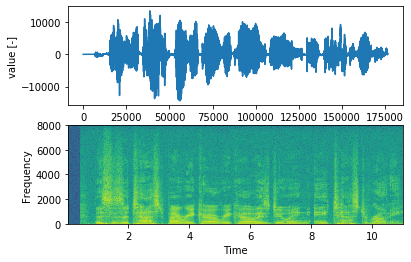

In [52]:
samples = record_and_stop(seconds=4)
audiolib.graph_raw_audio(samples)

In [53]:
sound[44000:44100]

array([ 3367,  3344,  3285,  3186,  3227,  3257,  3266,  3257,  3262,
        3191,  3140,  3107,  2994,  2886,  2738,  2590,  2459,  2257,
        1942,  1738,  1493,  1223,   956,   709,   474,   224,   -60,
        -332,  -501,  -877, -1252, -1560, -1954, -2439, -2723, -3069,
       -3356, -3543, -3687, -3791, -3888, -3893, -3915, -3795, -3790,
       -3684, -3590, -3531, -3357, -3171, -2935, -2683, -2487, -2280,
       -2009, -1738, -1449, -1156,  -860,  -533,  -247,    38,   319,
         634,   871,  1040,  1127,  1273,  1421,  1488,  1516,  1571,
        1593,  1612,  1649,  1643,  1737,  1766,  1866,  1859,  1850,
        1882,  1873,  1853,  1863,  1842,  1788,  1759,  1673,  1662,
        1633,  1669,  1697,  1646,  1536,  1510,  1501,  1435,  1393,
        1297], dtype=int16)

## Sliding Window Demo
To verify this is all working, let's make something that continuously records audio, then each second plots the audio from the last 4 seconds in the buffer.

In [67]:
from IPython.display import clear_output

def sound_sliding_window(seconds=15):
    """Demonstrate sliding window recording"""
    sound = SoundStreamer(seconds=4)
    sound.start()
    for i in range(seconds):
        time.sleep(1)
        samples = sound.sound_array()
        clear_output()
        audiolib.graph_raw_audio(samples)
    sound.stop()

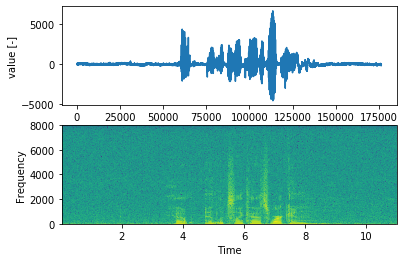

In [68]:
sound_sliding_window()

In [69]:
p = pyaudio.PyAudio()

In [71]:
p.get_default_input_device_info()

{'index': 1,
 'structVersion': 2,
 'name': 'Microphone (Realtek(R) Audio)',
 'hostApi': 0,
 'maxInputChannels': 2,
 'maxOutputChannels': 0,
 'defaultLowInputLatency': 0.09,
 'defaultLowOutputLatency': 0.09,
 'defaultHighInputLatency': 0.18,
 'defaultHighOutputLatency': 0.18,
 'defaultSampleRate': 44100.0}